In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#import tensorflow as tf

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.image as mpimg
from IPython.display import HTML

In [27]:
from simulator import Simulator, div

In [60]:
def force(m,n, w):
    f = np.zeros((m,n,2))
    f[-150:-2,236:276,0] = (-1 - w[-150:-2,236:276,0])
    #f[2:38,55:75,0] = (1 - w[2:38,55:75,0])
    f[-150:-2,236:276,:] += np.random.normal(size=(148,40,2))/30
    return f

def border_condition(w):
    w[0,:,0] = 0
    w[-1,:,0] = 0
    w[:,0,1] = 0
    w[:,-1,1] = 0

In [61]:
m,n = 512,512
sim = Simulator(m,n, 1, 0.01, border_condition, force)

(512, 512, 3)
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
CPU times: user 7min 30s, sys: 14.8 s, total: 7min 45s
Wall time: 2min


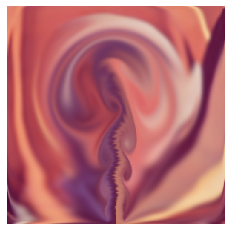

In [62]:
%%time


x = np.zeros((m,n,3))
#x[-5:-2,40:60,0] = 1.0
#x[2:5,40:60,2] = 1.0
x = mpimg.imread("LennaHD.png")
print(x.shape)


def take_scalar(a,indices_i, indices_j) :
    m,n = a.shape[:2]
    full_idices = n*indices_i + indices_j
    reshaped = a.reshape(m*n)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n)

def update_scalar(s,w,dt) :
    m,n = w.shape[:2]
    indices = np.indices((m,n)).swapaxes(0,2).swapaxes(0,1) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,0] = np.clip(indices_floor[:,:,0], 0, m-1)
    indices_ceil[:,:,0] = np.clip(indices_ceil[:,:,0], 0, m-1)
    indices_floor[:,:,1] = np.clip(indices_floor[:,:,1], 0, n-1)
    indices_ceil[:,:,1] = np.clip(indices_ceil[:,:,1], 0, n-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,2

    res = np.zeros((m,n))
    for i in range(2) :
        for j in range(2) :
            res += np.reshape(frac[i][:,:,0]*frac[j][:,:,1], (m,n)) * take_scalar(s, indices[i][:,:,0], indices[j][:,:,1])
    res = res*1
    #res[0:2,40:60] = 1
    return res

fig = plt.figure()
ims = []
for i in range(900) :
    dt=1
    sim.time_step(dt)
    x[:,:,0] = update_scalar(x[:,:,0],sim.w,dt)
    x[:,:,1] = update_scalar(x[:,:,1],sim.w,dt)
    x[:,:,2] = update_scalar(x[:,:,2],sim.w,dt)
    if not i % 20 :
        print(i)
    if not i % 3 :
        plt.axis('off')
        ims.append([plt.imshow(x, animated=True)])

In [64]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
ani1.save('lena_noise.mp4', writer=writer)

In [49]:
import cProfile
def test_func() :
    for i in range(100) :
        sim.time_step(dt)
cProfile.run('test_func()', 'restats')

In [20]:
import pstats
p = pstats.Stats('restats')
p.sort_stats('cumulative').print_stats(50)

Tue Nov 19 15:51:09 2019    restats

         10829706 function calls (10739044 primitive calls) in 12.015 seconds

   Ordered by: cumulative time
   List reduced from 456 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.015   12.015 {built-in method builtins.exec}
        1    0.000    0.000   12.015   12.015 <string>:1(<module>)
        1    0.000    0.000   12.015   12.015 <ipython-input-14-79df4a85f0ea>:2(test_func)
      100    0.003    0.000   12.015    0.120 /Data/leo_h/stable-fluids/simulator.py:194(time_step)
      100    0.004    0.000   10.015    0.100 /Data/leo_h/stable-fluids/simulator.py:174(compute_w4)
      100    0.036    0.000    9.817    0.098 /Data/leo_h/stable-fluids/simulator.py:59(conjgrad_lap)
     3809    0.113    0.000    8.365    0.002 /Data/leo_h/stable-fluids/simulator.py:50(conjgrad_lap_step)
   154815    4.969    0.000    4.971    0.000 {built-in method _pywrap_tensorfl